In [1]:
import pandas as pd

In [8]:
MODEL = "meta-llama/Meta-Llama-3.1-8B"
BASE_PPL = 5.606692790985107

In [3]:
data_df = pd.read_csv('/tmp/galqiwi/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL.csv')

data_df['layer'] = data_df['layer_name']
data_df['mse'] = data_df['relative_mse']

data_df = data_df[data_df['base_model'] == MODEL]

data_df = data_df[['layer', 'mse', 'wikitext2']]
data_df = data_df.dropna().copy()

/var/tmp/ipykernel_845573/3485746776.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('/tmp/galqiwi/NOISY_MSE_ONE_LINEAR_LAYER_GALQIWI_PPL.csv')


In [50]:
import statsmodels.api as sm


def get_scale(x, y):
    model = sm.OLS(y, x).fit()
    lower, upper = model.conf_int(alpha=0.05).values[0]
    mid = (lower + upper) / 2
    err = (upper - lower) / 2
    return mid, err

In [54]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

layers = sorted(set(data_df['layer']))

means = []
errors = []
slopes = []

for layer_idx, layer in enumerate(layers):
    to_fit = data_df[data_df['layer'] == layer]
    to_fit = to_fit[to_fit['mse'] < 4 ** -1.7]
    to_fit = to_fit[to_fit['mse'] > 0.02]
    
    mid, err = get_scale(to_fit['mse'], to_fit['wikitext2'] - BASE_PPL)
    slope = LinearRegression(fit_intercept=False).fit(to_fit['mse'].values.reshape(-1, 1), (to_fit['wikitext2'] - BASE_PPL).values).coef_.item()

    # plt.scatter(to_fit['mse'], to_fit['wikitext2'] - BASE_PPL)
    # grid = np.linspace(0, 0.09, 10)
    # plt.plot(grid, grid * mid)
    
    means.append(mid)
    errors.append(err)
    slopes.append(slope)

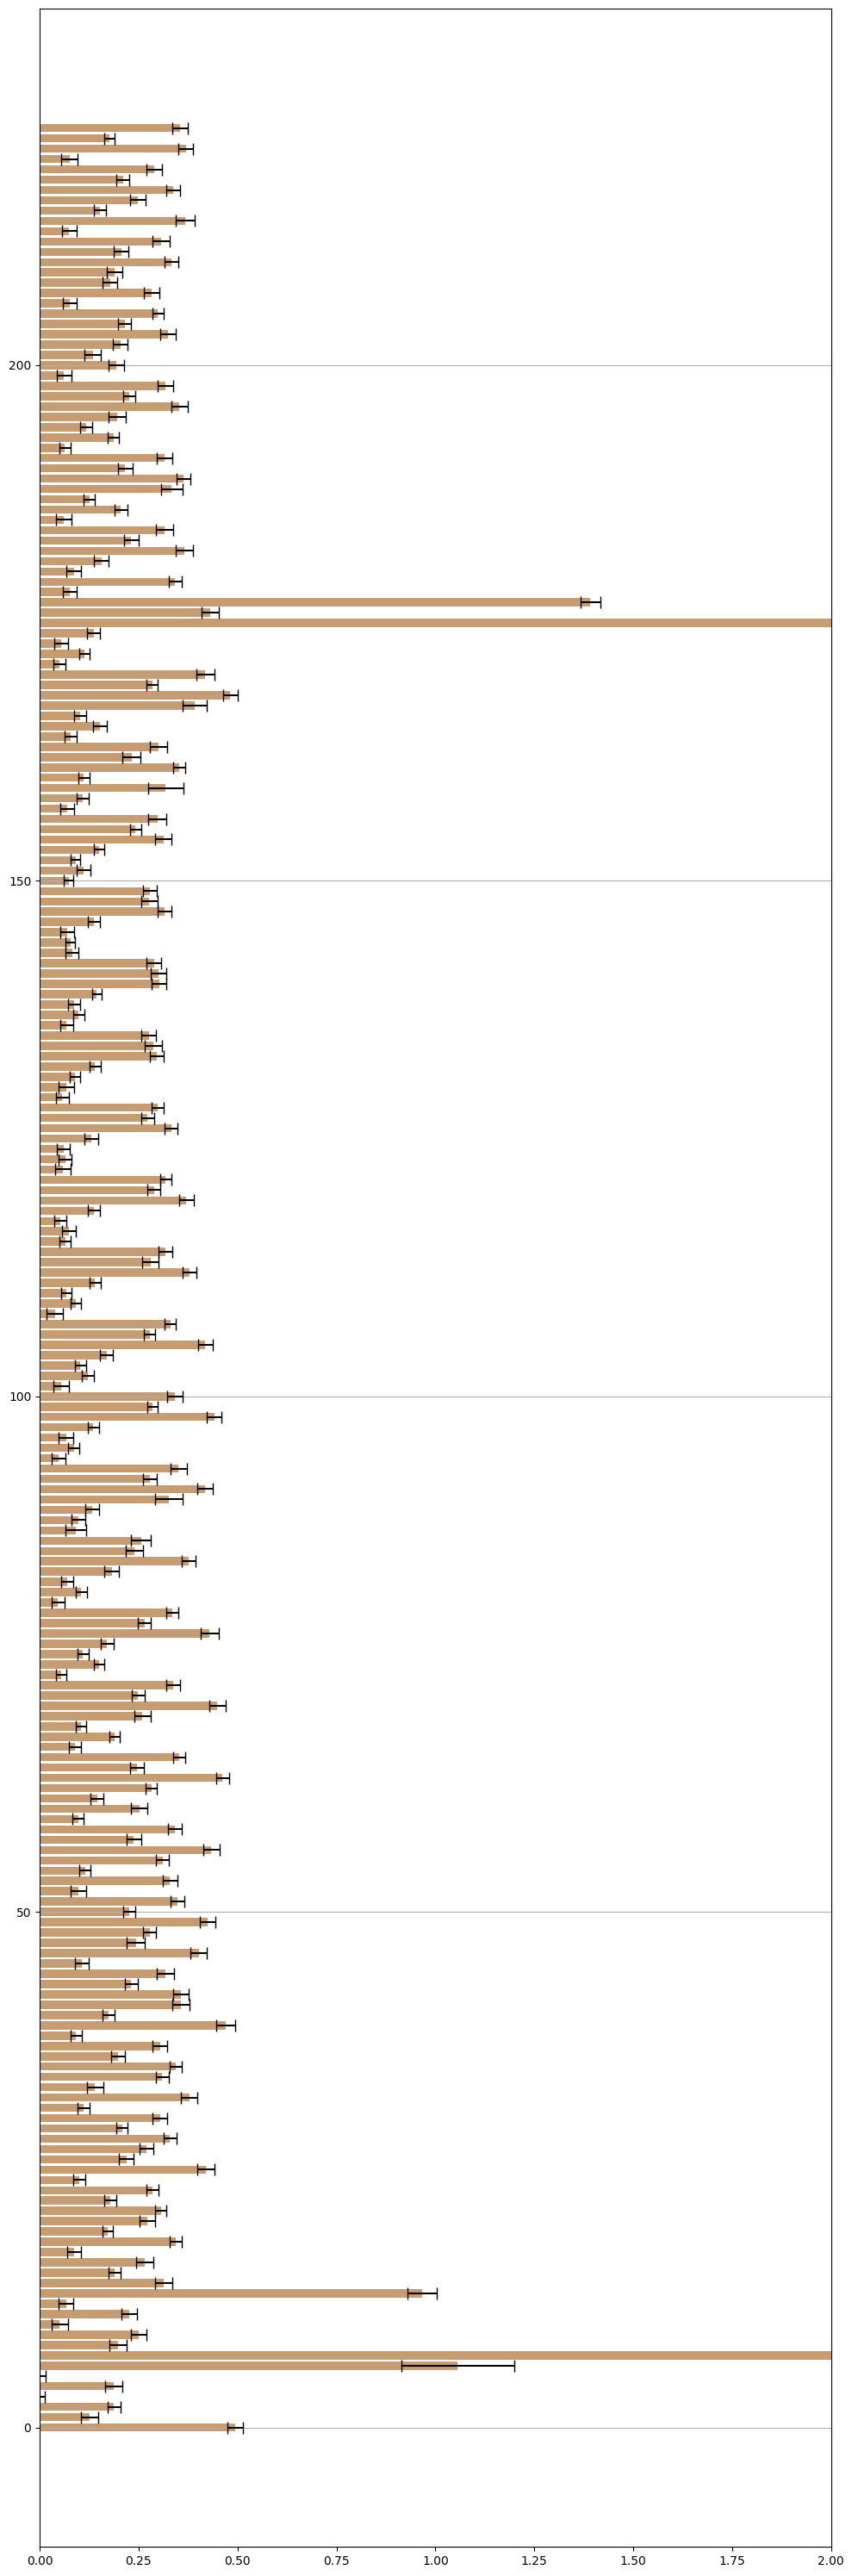

In [59]:
import numpy as np
fig, ax = plt.subplots(figsize=(10, 30))

x = np.arange(len(layers))  # x locations for the groups
ax.barh(x, means, xerr=errors, capsize=5, align='center', alpha=0.5, ecolor='black')
ax.barh(x, slopes, capsize=5, align='center', alpha=0.5, ecolor='black')
ax.yaxis.grid(True)

plt.xlim([0, 2.0])

# Save the figure or show
plt.tight_layout()
plt.savefig('conf_llama3_8b.png')
plt.show()
